# Group Members:

*   Name 1 Albert Santos Moya 240690
*   Name 2 Elsa Ruiz Vargas 241545
*   Name 3 Héctor Naranjo Rodríguez 240498

# Lab 3 Assignment (Part 2)

In [342]:
#from google.colab import drive
#drive.mount('/content/drive')

In [343]:
#%cd "PUT_YOUR_PATH"

In [344]:
# Install if required
# !python -m pip install opencv-python

In [345]:
import numpy as np
from PIL import Image 
import os
import cv2 as cv
import matplotlib.pyplot as plt
from math import sqrt
from IPython.display import clear_output, display

#### **1. Complete the code required in the cells by following the comments provided in the code.**

**Read the images**

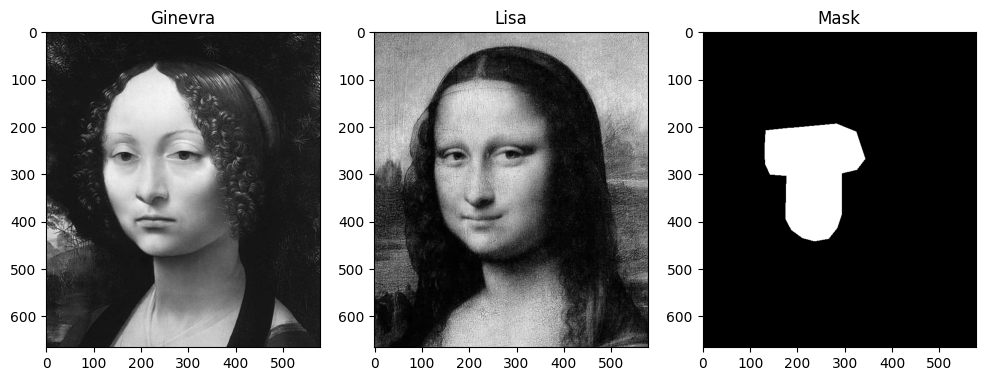

In [346]:
# Define the images directory
images_dir = os.path.abspath("../images")

# Read all the required images
ginevra = Image.open(os.path.join(images_dir, "ginevra.png"))
lisa = Image.open(os.path.join(images_dir, "lisa.png"))
mask = Image.open(os.path.join(images_dir, "mask.png"))

# Convert all the images to 2D
u1 = np.array(ginevra, dtype = float)[:, :, 0]
u2 = np.array(lisa, dtype = float)[:, :, 0]
mask = np.array(mask, dtype = float) / 255

# Show all the images
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))
ax1.imshow(u1, cmap = "gray")
ax1.set_title("Ginevra")
ax2.imshow(u2, cmap = "gray")
ax2.set_title("Lisa")
ax3.imshow(mask, cmap = "gray")
ax3.set_title("Mask")
plt.show()

**Apply filters to images**

Learn more about Gaussian blurring [here](https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)

In [347]:
u1 = cv.GaussianBlur(src = u1, ksize = (9, 9), sigmaX = 2, borderType = cv.BORDER_REFLECT)
u2 = cv.GaussianBlur(src = u2, ksize = (11, 11), sigmaX = 4, borderType = cv.BORDER_REFLECT)

**Crude composition**

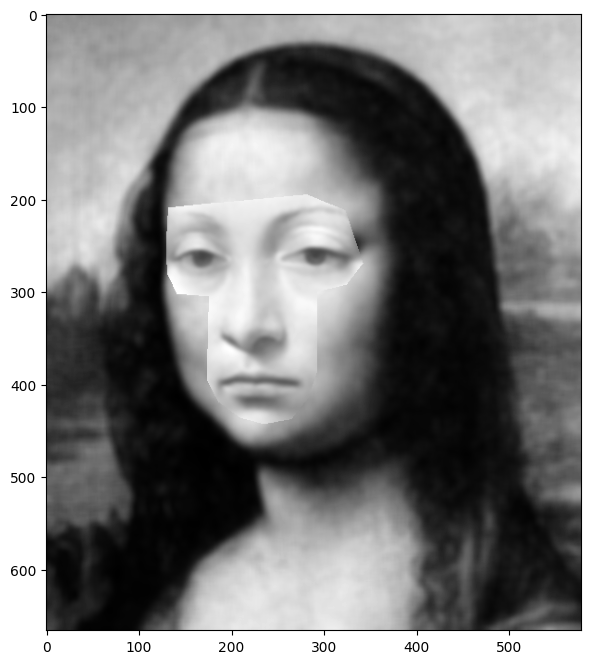

In [348]:
# TODO: generate an image which is u1 when mask = 1, and u2 when mask = 0

# initialize the composed image
ucomp = np.zeros_like(u1)

# u1 when mask = 1
ucomp[mask == 1] = u1[mask == 1]
# u2 when mask = 0
ucomp[mask == 0] = u2[mask == 0]

# Show the composed image
plt.figure(figsize = (12, 8))
plt.imshow(ucomp, cmap = "gray")

**Guiding vector field**

We compose the images, but at the gradient level!

Let:

$\nabla^+ u_{1,ij}= (\nabla^+_i u_{1,ij}, \nabla^+_j u_{1,ij})$

$\nabla^+ u_{2,ij}= (\nabla^+_i u_{2,ij}, \nabla^+_j u_{2,ij})$

for $i=1,2,\cdots M,j=1,2,\cdots N.$

$\quad$

Then 
\begin{align*}
v_{ij} &= m_{ij}\nabla^+ u_{1,ij} + (1-m_{ij})\nabla^+ u_{2,ij}\\
&=(m_{ij}\nabla^+_i u_{1,ij} + (1-m_{ij})\nabla^+_i u_{2,ij}\quad ,\quad m_{ij}\nabla^+_j u_{1,ij} + (1-m_{ij})\nabla^+_j u_{2,ij})\\
&=(v_{1,ij} ,v_{2,ij})
\end{align*}




In [349]:
def im_fwd_gradient(image: np.matrix):
    """
    Discrete gradient of an image using forward differences, with homogeneous Neuman boundary conditions.

    :param u: image (MxN)
            
    :return gradu_j: partial derivative in the j (rows) direction (also x direction)
    :return gradu_i: partial derivative in the i (cols) direction (also y direction)
    """
    # Get the size of the image
    image_shape = image.shape
    
    # Calculate both gradients
    gradu_j = np.append(np.diff(image, axis = 1), np.zeros((image_shape[0], 1)), axis = 1)
    gradu_i = np.append(np.diff(image, axis = 0), np.zeros((1, image_shape[1])), axis = 0)
    return gradu_i, gradu_j

In [350]:
# TODO: Compute the gradients of u1 and u2, and define a new gradient [vi,vj] 
#       which corresponds to the gradient of u1 when mask = 1, and the gradient 
#       of u2 when mask = 0

# Compute the gradient of the images
gradu1_i, gradu1_j = im_fwd_gradient(u1)
gradu2_i, gradu2_j = im_fwd_gradient(u2)

# Calculate v

# new gradient [vi,vj]  which corresponds to the gradient of u1 when mask = 1, and the gradient of u2 when mask = 0
vi, vj = np.zeros_like(u1), np.zeros_like(u2)

vi[mask == 1] = gradu1_i[mask == 1]
vi[mask == 0] = gradu2_i[mask == 0]
vj[mask == 1] = gradu1_j[mask == 1]
vj[mask == 0] = gradu2_j[mask == 0]




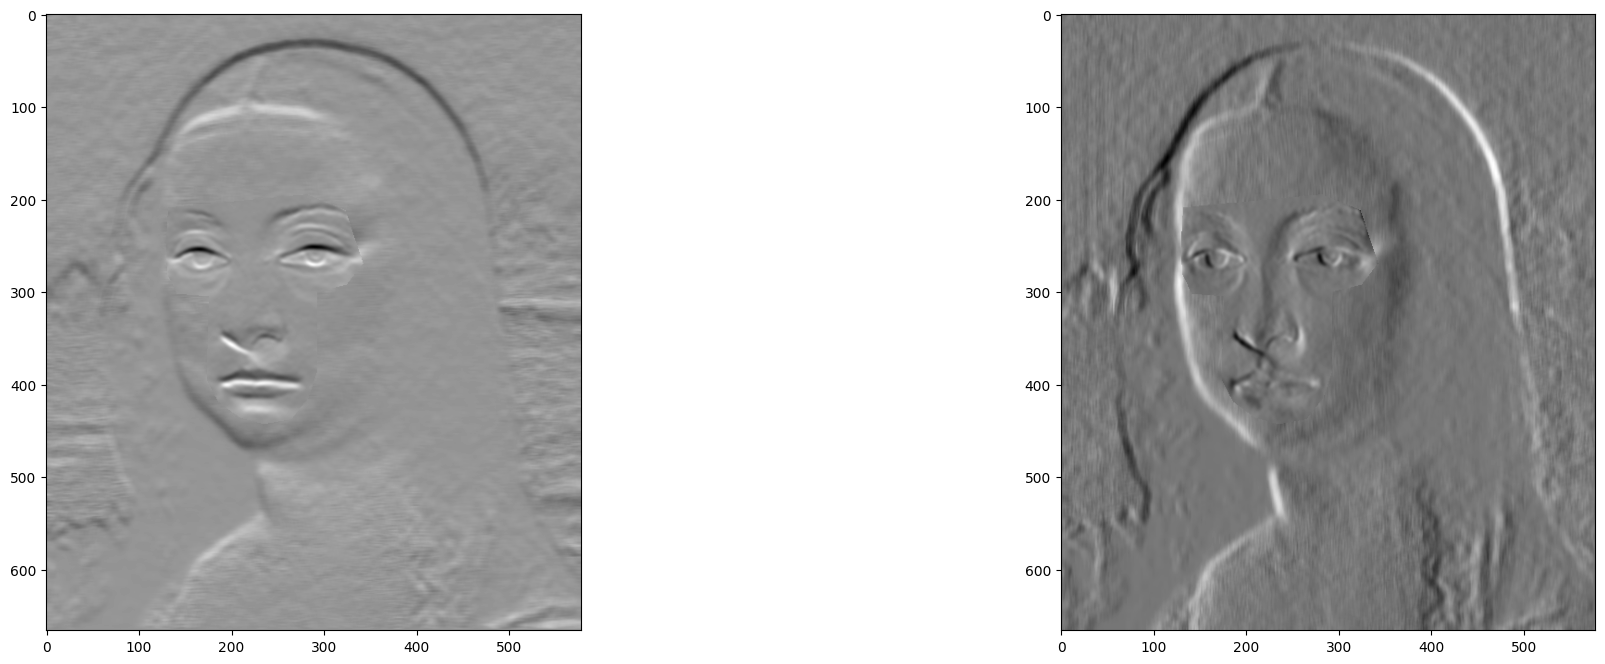

In [351]:
plt.figure(figsize = (24, 8))
plt.subplot(1,2,1)
plt.imshow(vi, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(vj, cmap = "gray")

Find $u$ that minimizes the energy function:
$$E(u) = \overbrace{\dfrac{1}{2}\sum_{i = 1}^N\sum_{j = 1}^M |\nabla^+u_{ij} - v_{ij}|_{\mathbb R^2}^2}^{\text{gradients similar to $v$}} +
\overbrace{\dfrac{1}{2}\sum_{i = 1}^N\sum_{j = 1}^M \beta_{ij}(u_{ij} - u_{2,ij})^2}^{\text{$u$ is $u_{2}$ outside the mask}}$$

where:

$\beta_{ij} = \beta_{0} (1-m_{ij})$

**Conjugate gradient set up**

With

\begin{align*}
E(u) &= \overbrace{\dfrac{1}{2}\langle\nabla^+u - v, \nabla^+u - v\rangle_{Y}}^{\text{gradients similar to $v$}} +
\overbrace{\dfrac{1}{2}\langle B(u - u_{2}), u - u_{2}\rangle_{X}}^{\text{$u$ is $u_{2}$ outside the mask}}\\
&\\
&\\
\nabla E(u) &= -div^{-}(\nabla^{+}u - v) + B(u - u_{2})
\end{align*}

In [352]:
def im_bwd_divergence(gradient_i: np.matrix,
                      gradient_j: np.matrix):
    """
    Discrete divergence of a vector field using backwards differences. 
    This is the negative transpose of the im_fwd_gradient
    
    :param gradient_i: component of g in the direction j (rows) (also x direction)
    :param gradient_j: component of g in the direction i (cols) (also y direction)
    
    :return divg: backwards divergence of g
    """
    # Backwards j partial derivative of gradient_j
    gradient_j[:, gradient_j.shape[1] - 1] = 0
    divg = np.diff(np.append(np.zeros((gradient_j.shape[0], 1)), gradient_j, axis = 1), axis = 1)
    
    # Backwards i partial derivative of gradient_i
    gradient_i[gradient_i.shape[0] - 1, :] = 0
    divg = np.diff(np.append(np.zeros((1, gradient_i.shape[1])), gradient_i, axis = 0), axis = 0) + divg
    
    return divg

**Define the variable term**

\begin{align*}
\nabla E(u) &= -div^{-}(\nabla^{+}u - v) + B(u - u_{2})\\
&= \overbrace{[-div^{-}(\nabla^{+}u) + B*u]}^{\text{variable term}}-\overbrace{[-div^{-}(v) + B*u_{2}]}^{\text{constant term}}\\
\end{align*}

With

$\begin{align*}
Ax&= -div^{-}(\nabla^{+}u) + B*u\\
b&= -div^{-}(v) + B*u_{2}
\end{align*}$


$$\nabla E(u) = Ax - b$$

In [353]:
def poisson_linear_operator(u, beta):
    """
    Discrete laplacian of an image using a forward gradient and 
    a backward divergence. It computes the Laplacian inside a region indicated by a 
    mask (mask = 1). It assumes u(x) = 0 for x outside the mask (homogeneous
    Dirichlet boundary conditions). The interface is compatible with
    conjugate_gradient and gradient_descent.

    lap = im_laplacian_mask(u,prms)

    param u: image (MxN)
    param prms: structure with one field, prms.mask, a (MxN) binary image

    :return lap: laplacian
    """
    gu_i , gu_j = im_fwd_gradient(u)
    lapu = (-1) * im_bwd_divergence(gu_i, gu_j)
    return lapu + beta * u

In [354]:
def conjugate_gradient(callback,
                       b: np.matrix,
                       callback_params: dict,
                       initial_condition: np.matrix,
                       tolerance: float,
                       max_iters: int,
                       fig = None,
                       ax = None):
    """
    implementation of the conjugate gradient algorithm for the minimization of quadratic problems 

       f(x) = 1/2 x'Ax - bx. 

    It uses function handles. It requires a handle to a Python function that implements the product of matrix A with x.

    :param callback: handle (pointer) to a matlab function implementing the product with matrix A. 
    :param callback_params: dictionary containing the params for the callback functions
    :param b: vector b, can be in matrix form (MxN)
    :param initial_conditions: initial condition, same dimensions as b (MxN)
    :param max_iters: maximum number of iterations
    :param tolerance: tolerance for the stopping condition (it stop when the norm of the gradient is below the tolerance)

    :return x: value found (MxN)
    :return fs: evolution of the target function (total_iters x 1 vector)
    """

    # NOTE: Copy and paste the function you already implemented in the first part of the exercise
    x = np.zeros_like(initial_condition)
    r = b - callback(initial_condition, **callback_params)
    d = r
    rsold = np.sum(r * r)
    fs = []
    for i in range(max_iters):
         q = callback(d, **callback_params)
         alpha = rsold / np.sum(d * q)
         x = x + alpha * d
         r = r - alpha * q
         rsnew = np.sum(r * r)
         fs.append(rsnew)
         if sqrt(rsnew) < tolerance:
               break
         d = r + (rsnew / rsold) * d
         rsold = rsnew
    return x, fs
   


#### **2. Once you have completed all the code above, now implemented into the function lisa_ginevra_test and explain with your own words the main steps of the algorithm**

**Define the constant term**

\begin{align*}
\nabla E(u) &= -div^{-}(\nabla^{+}u - v) + B(u - u_{2})\\
&= \overbrace{[-div^{-}(\nabla^{+}u) + B*u]}^{\text{variable term}}-\overbrace{[-div^{-}(v) + B*u_{2}]}^{\text{constant term}}\\
\end{align*}

With

$\begin{align*}
Ax&= -div^{-}(\nabla^{+}u) + B*u\\
b&= -div^{-}(v) + B*u_{2}
\end{align*}$


$$\nabla E(u) = Ax - b$$

Recall that:
\begin{align*}
v_{ij} &= m_{ij}\nabla^+ u_{1,ij} + (1-m_{ij})\nabla^+ u_{2,ij}\\
&=(m_{ij}\nabla^+_i u_{1,ij} + (1-m_{ij})\nabla^+_i u_{2,ij}\quad ,\quad m_{ij}\nabla^+_j u_{1,ij} + (1-m_{ij})\nabla^+_j u_{2,ij})\\
&=(v_{1,ij} ,v_{2,ij})
\end{align*}

In [355]:
def lisa_ginevra_test(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    """
    uses Poisson editing to interchange the faces of Ginevra de' Benci and Lisa Gherardini
    
    :param u1: Ginevra's image
    :param u2: Lisa's image
    """
    # TODO: CRUDE COMPOSITION
    # initialize the composed image
    ucomp = np.zeros_like(u1)
    # u1 when mask = 1
    ucomp[mask == 1] = u1[mask == 1]
    # u2 when mask = 0
    ucomp[mask == 0] = u2[mask == 0]
    
    # TODO: GUIDING VECTOR FIELD
    # Compute the gradient of the images
    gradu1_i, gradu1_j = im_fwd_gradient(u1)
    gradu2_i, gradu2_j = im_fwd_gradient(u2)

    vi[mask == 1] = gradu1_i[mask == 1]
    vi[mask == 0] = gradu2_i[mask == 0]

    vj[mask == 1] = gradu1_j[mask == 1]
    vj[mask == 0] = gradu2_j[mask == 0]

    # Define beta_0 and calculate beta
    beta_0 = 20                            # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)  # TRY CHANGING    
    tolerance = 1                          # TRY CHANGING
    max_iters = 1000                       # TRY CHANGING
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Ginevra")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Lisa")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

Explanation of the algorithm: The lisa_ginevra_test function performs an algorithm to swap the faces of Ginevra de' Benci and Lisa Gherardini using Poisson editing. Main steps:

1. Crude Composition: As done previously pixels corresponding to Ginevra's face (mask = 1) are taken from u1, and pixels corresponding to Lisa's face (mask = 0) are taken from u2.
2. Guiding Vector Field: We compute the gradients of u1 and u2 and create new vectors vi and vj by combining the gradients based on the mask: Ginevra's gradients are used where the mask is 1, and Lisa's gradients are used where the mask is 0.
3. Define Beta: We define a constant value beta_0 and calculate beta by multiplying beta_0 with the complement of the mask (1 - mask). This coefficient controls the attachment to u2 and influences the blending of the faces in the final composition.
4. Calculate Right Hand Term with boundary data: We compute the divergence of the gradient field and negate the result.  The divergence measures the rate of flow or change in the gradient field. We add beta * u2 to the negated divergence to create the right-hand term b for **for solving the Poisson equation** which represents the boundary conditions for it. 
5. Conjugate Gradient: We use the conjugate gradient method to solve the Poisson equation and obtain the solution upns. We set the initial condition, tolerance, and maximum number of iterations for the solver.
6. Plot the images, outcomes are visuallized

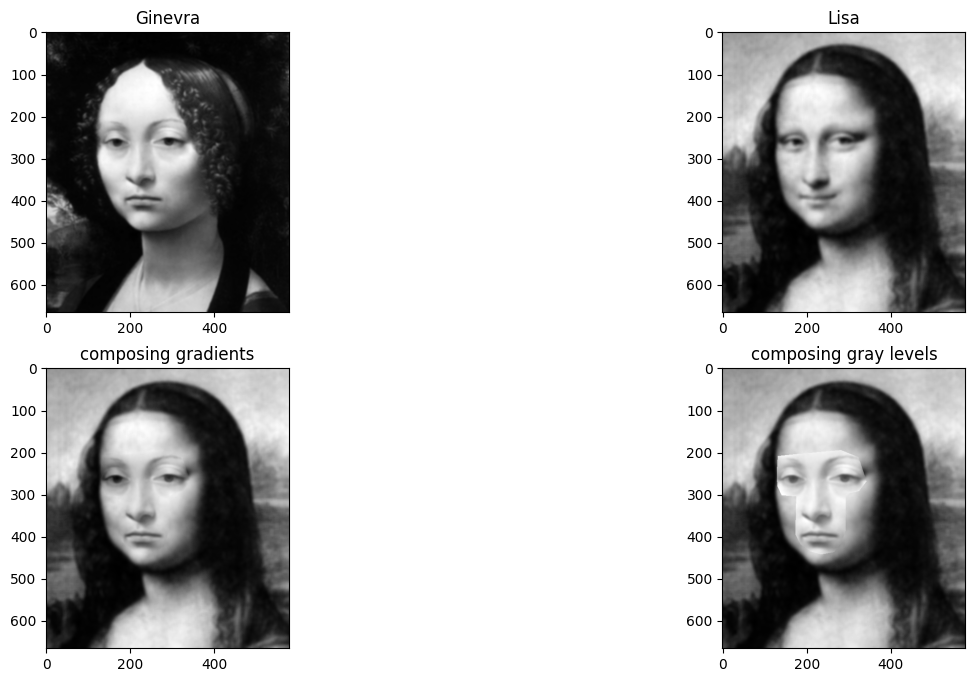

In [356]:
lisa_ginevra_test(u1, u2, mask)

#### **3. Run the function lisa_ginevra_test using different parameters and explain the differences**

In [357]:
def lisa_ginevra_test_b0(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    """
    Changing beta_0 experiment
    uses Poisson editing to interchange the faces of Ginevra de' Benci and Lisa Gherardini
    
    :param u1: Ginevra's image
    :param u2: Lisa's image
    """
    # TODO: CRUDE COMPOSITION
    # initialize the composed image
    ucomp = np.zeros_like(u1)
    # u1 when mask = 1
    ucomp[mask == 1] = u1[mask == 1]
    # u2 when mask = 0
    ucomp[mask == 0] = u2[mask == 0]
    
    # TODO: GUIDING VECTOR FIELD
    # Compute the gradient of the images
    gradu1_i, gradu1_j = im_fwd_gradient(u1)
    gradu2_i, gradu2_j = im_fwd_gradient(u2)

    vi[mask == 1] = gradu1_i[mask == 1]
    vi[mask == 0] = gradu2_i[mask == 0]

    vj[mask == 1] = gradu1_j[mask == 1]
    vj[mask == 0] = gradu2_j[mask == 0]

    # Define beta_0 and calculate beta
    beta_0 = 0                          # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)    
    tolerance = 1                          
    max_iters = 1000                       
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Ginevra")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Lisa")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

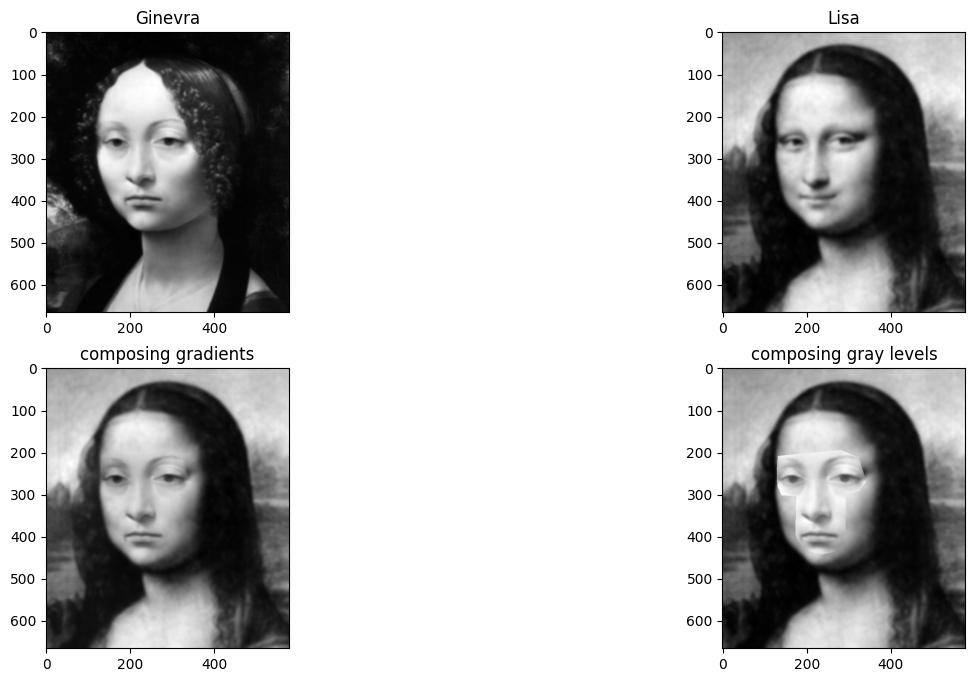

In [358]:
lisa_ginevra_test_b0(u1, u2, mask)

The change of the initial beta will be important in the following aspects: We have seen that if we increase too much the b0 (100) Lisa will be the face in the composing gradient and in composing gray levels we can just see the black of the mask where should be Ginevra's face. (explained in own words). And if setting it to 0 the inverse
**Conclusions:** Changing the value of beta_0 in the code directly affects the balance between the swapped faces. 
1. A higher beta_0 gives more weight to the second image (u2), resulting in a composition where the swapped face resembles it more. 
2. Conversely, a lower beta_0 reduces the weight of u2, making the swapped face resemble the first image (u1) more prominently. 
Finding the right beta_0 value is crucial to achieve a visually pleasing and balanced face swap, ensuring a smooth transition and preserving important characteristics of each face.

In [359]:
def lisa_ginevra_test_in(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    """
    Changing beta_0 experiment
    uses Poisson editing to interchange the faces of Ginevra de' Benci and Lisa Gherardini
    
    :param u1: Ginevra's image
    :param u2: Lisa's image
    """
    # TODO: CRUDE COMPOSITION
    # initialize the composed image
    ucomp = np.zeros_like(u1)
    # u1 when mask = 1
    ucomp[mask == 1] = u1[mask == 1]
    # u2 when mask = 0
    ucomp[mask == 0] = u2[mask == 0]
    
    # TODO: GUIDING VECTOR FIELD
    # Compute the gradient of the images
    gradu1_i, gradu1_j = im_fwd_gradient(u1)
    gradu2_i, gradu2_j = im_fwd_gradient(u2)

    vi[mask == 1] = gradu1_i[mask == 1]
    vi[mask == 0] = gradu2_i[mask == 0]

    vj[mask == 1] = gradu1_j[mask == 1]
    vj[mask == 0] = gradu2_j[mask == 0]

    # Define beta_0 and calculate beta
    beta_0 = 20                            # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = u1 # TRY CHANGING    
    tolerance = 1                          # TRY CHANGING
    max_iters = 1000                       # TRY CHANGING
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Ginevra")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Lisa")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

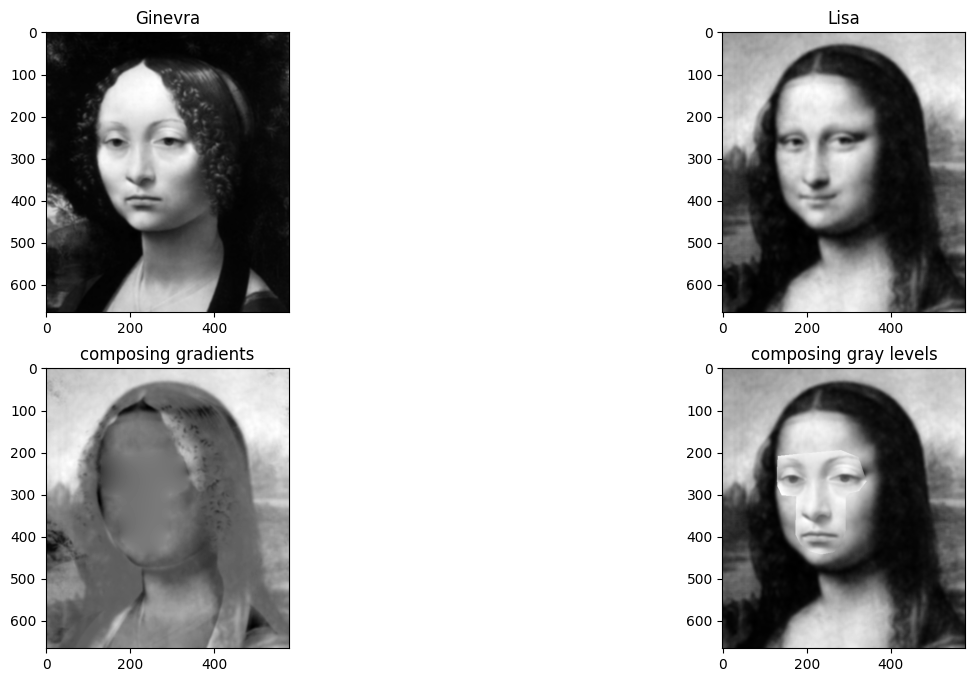

In [360]:
lisa_ginevra_test_in(u1, u2, mask)

As we could observe, the initial_condition determines the starting point for the face swap algorithm. 
1. Setting it to np.zeros_like(u1) means that the algorithm begins with a neutral image. 
2. Changing it to np.ones_like(u1) or u1 would introduce an initial image with different characteristics. 
Modifying the initial_condition can affect the convergence speed and the final result of the face swap, allowing you to adjust the balance between the two faces in the merged composition.





In [361]:
def lisa_ginevra_test_tol(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    """
    Changing beta_0 experiment
    uses Poisson editing to interchange the faces of Ginevra de' Benci and Lisa Gherardini
    
    :param u1: Ginevra's image
    :param u2: Lisa's image
    """
    # TODO: CRUDE COMPOSITION
    # initialize the composed image
    ucomp = np.zeros_like(u1)
    # u1 when mask = 1
    ucomp[mask == 1] = u1[mask == 1]
    # u2 when mask = 0
    ucomp[mask == 0] = u2[mask == 0]
    
    # TODO: GUIDING VECTOR FIELD
    # Compute the gradient of the images
    gradu1_i, gradu1_j = im_fwd_gradient(u1)
    gradu2_i, gradu2_j = im_fwd_gradient(u2)

    vi[mask == 1] = gradu1_i[mask == 1]
    vi[mask == 0] = gradu2_i[mask == 0]

    vj[mask == 1] = gradu1_j[mask == 1]
    vj[mask == 0] = gradu2_j[mask == 0]

    # Define beta_0 and calculate beta
    beta_0 = 20                            # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)  # TRY CHANGING    
    tolerance = 2                          # TRY CHANGING
    max_iters = 1000                       # TRY CHANGING
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Ginevra")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Lisa")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

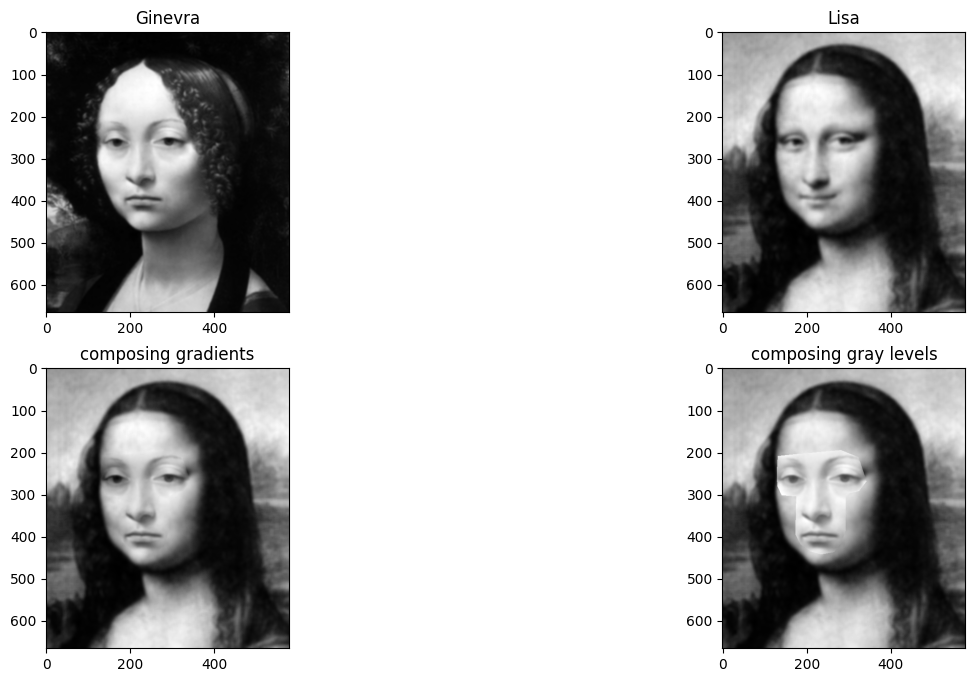

In [362]:
lisa_ginevra_test_tol(u1, u2, mask)

Changing the tolerance value affects the trade-off between accuracy and speed in the face swap algorithm. 
1. A lower tolerance means the algorithm aims for a more precise result, even if it takes more time to converge. 
2. A higher tolerance allows for a faster but potentially less accurate outcome. 
Adjusting the tolerance allows us to control the balance between the quality of the final face swap and the computational efficiency of the algorithm.

In [363]:
def lisa_ginevra_test_its(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    """
    Changing beta_0 experiment
    uses Poisson editing to interchange the faces of Ginevra de' Benci and Lisa Gherardini
    
    :param u1: Ginevra's image
    :param u2: Lisa's image
    """
    # TODO: CRUDE COMPOSITION
    # initialize the composed image
    ucomp = np.zeros_like(u1)
    # u1 when mask = 1
    ucomp[mask == 1] = u1[mask == 1]
    # u2 when mask = 0
    ucomp[mask == 0] = u2[mask == 0]
    
    # TODO: GUIDING VECTOR FIELD
    # Compute the gradient of the images
    gradu1_i, gradu1_j = im_fwd_gradient(u1)
    gradu2_i, gradu2_j = im_fwd_gradient(u2)

    vi[mask == 1] = gradu1_i[mask == 1]
    vi[mask == 0] = gradu2_i[mask == 0]

    vj[mask == 1] = gradu1_j[mask == 1]
    vj[mask == 0] = gradu2_j[mask == 0]

    # Define beta_0 and calculate beta
    beta_0 = 20                            # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)  # TRY CHANGING    
    tolerance = 1                          # TRY CHANGING
    max_iters = 100                     # TRY CHANGING
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Ginevra")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Lisa")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

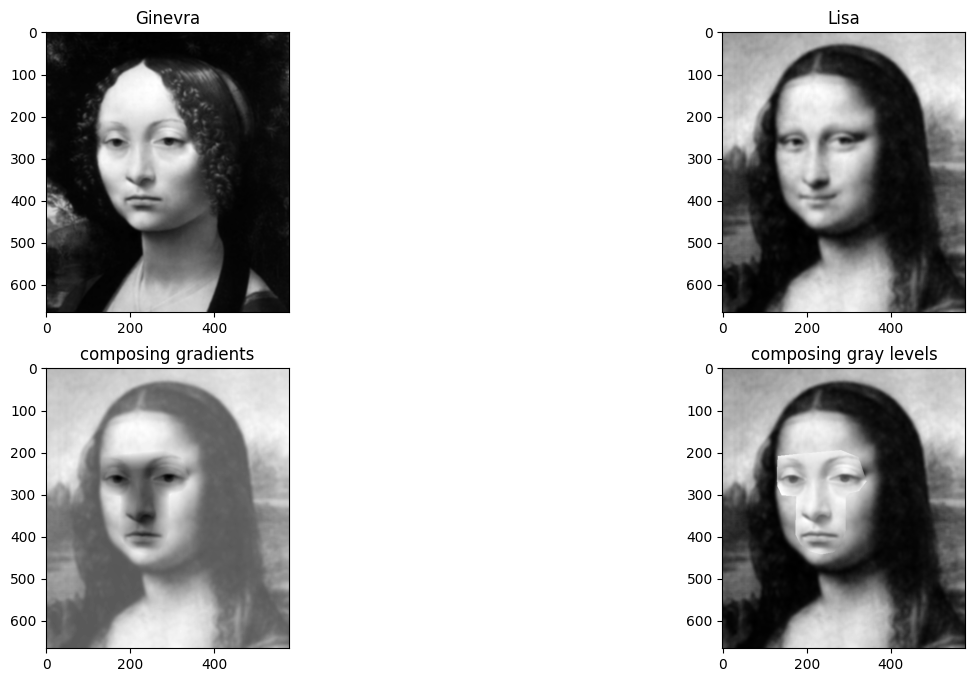

In [364]:
lisa_ginevra_test_its(u1, u2, mask)

More iterations can lead to a more detailed and accurate face swap, but it also takes more time to compute. Fewer iterations may result in a quicker outcome, but with potentially less precision. Therefore, adjusting the number of iterations allows for a trade-off between the quality of the face swap and the computational time required.

#### **4. Take a picture of two different faces (u1 and u2) and apply Poisson editing (it will be better if the faces are from the two components of the group). Try using u1 as a background and the face of u2 and the way around. Notice that you will need to create your own mask.**

0.0
0.0
0.0


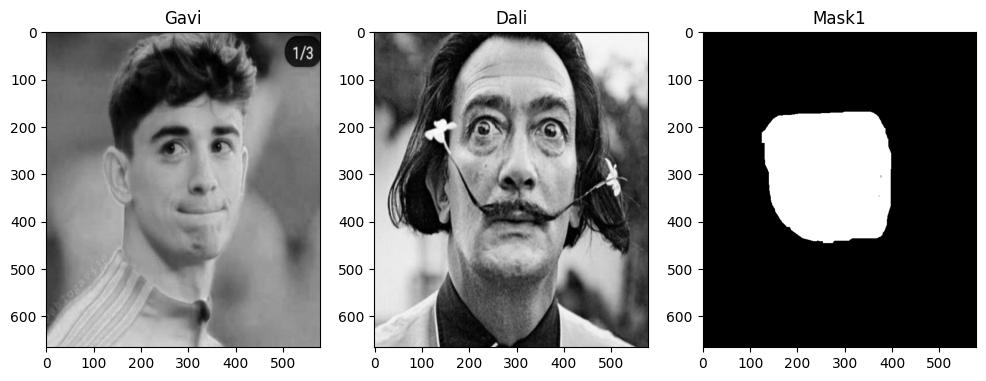

In [365]:

# Read all the required images
gavi = Image.open(os.path.join(images_dir, "gavi.jpeg"))
dali = Image.open(os.path.join(images_dir, "dali.jpeg"))
mask1 = Image.open(os.path.join(images_dir, "mask copia.png"))


# Convert all the images to 2D
u11 = np.array(gavi, dtype = float)[:, :, 0]
u21 = np.array(dali, dtype = float)[:, :, 0]
mask1 = np.array(mask1, dtype = float) / 255


# make gavi image to gray scale
gavi = gavi.convert('L')


# reecale all images to the same size
u11 = cv.resize(u11, (mask.shape[1], mask.shape[0]))
mask1 = cv.resize(mask1, (mask.shape[1], mask.shape[0]))
u21 = cv.resize(u21, (mask.shape[1], mask.shape[0]))

# mask 1 
print(mask1[0,0,1])
# eliminate the alpha channel
mask1 = mask1[:,:,0]
print(mask1[0,0])
# put all mask 1 values to 0.0 or 1.0
mask1[mask1 < 0.5] = 0.0
mask1[mask1 >= 0.5] = 1.0
print(mask[0,0])

# Show all the images
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))
ax1.imshow(u11, cmap = "gray")
ax1.set_title("Gavi")
ax2.imshow(u21, cmap = "gray")
ax2.set_title("Dali")
ax3.imshow(mask1, cmap = "gray")
ax3.set_title("Mask1")
plt.show()

u11 = cv.GaussianBlur(src = u11, ksize = (9, 9), sigmaX = 2, borderType = cv.BORDER_REFLECT)
u21 = cv.GaussianBlur(src = u21, ksize = (11, 11), sigmaX = 4, borderType = cv.BORDER_REFLECT)


In [366]:
def lisa_gavi_in_dali(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    """
    Changing beta_0 experiment
    uses Poisson editing to interchange the faces of Ginevra de' Benci and Lisa Gherardini
    
    :param u1: Ginevra's image
    :param u2: Lisa's image
    """
    # TODO: CRUDE COMPOSITION
    # initialize the composed image
    ucomp = np.zeros_like(u1)
    # u1 when mask = 1
    ucomp[mask == 1] = u1[mask == 1]
    # u2 when mask = 0
    ucomp[mask == 0] = u2[mask == 0]
    
    # TODO: GUIDING VECTOR FIELD
    # Compute the gradient of the images
    gradu1_i, gradu1_j = im_fwd_gradient(u1)
    gradu2_i, gradu2_j = im_fwd_gradient(u2)

    vi[mask == 1] = gradu1_i[mask == 1]
    vi[mask == 0] = gradu2_i[mask == 0]

    vj[mask == 1] = gradu1_j[mask == 1]
    vj[mask == 0] = gradu2_j[mask == 0]

    # Define beta_0 and calculate beta
    beta_0 = 20                            # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)  # TRY CHANGING    
    tolerance = 2                          # TRY CHANGING
    max_iters = 2000                       # TRY CHANGING
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Gavi")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Dali")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

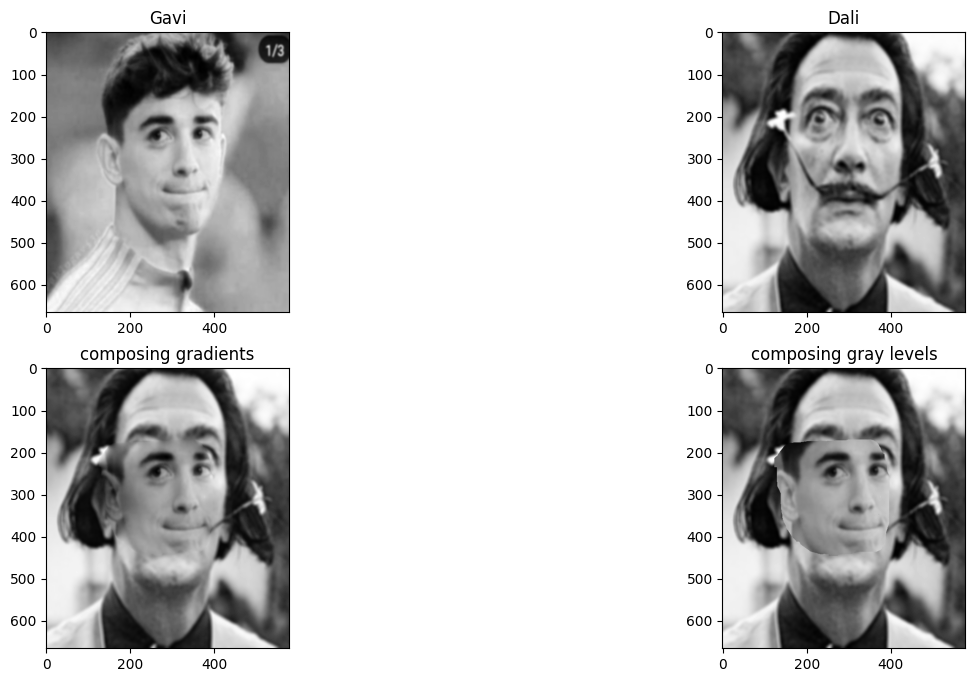

In [367]:

lisa_gavi_in_dali(u11, u21, mask1)

This one does not look that good but it is because of the mask we created and the faces differences and orientations. Not the best images choosen. It was difficult to create a mask that suited! Nevertheless, the other one looks better

In [368]:
def lisa_dali_in_gavi(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    """
    Changing beta_0 experiment
    uses Poisson editing to interchange the faces of Ginevra de' Benci and Lisa Gherardini
    
    :param u1: Ginevra's image
    :param u2: Lisa's image
    """
    # TODO: CRUDE COMPOSITION
    # initialize the composed image
    ucomp = np.zeros_like(u1)
    # u1 when mask = 1
    ucomp[mask == 1] = u1[mask == 1]
    # u2 when mask = 0
    ucomp[mask == 0] = u2[mask == 0]
    
    # TODO: GUIDING VECTOR FIELD
    # Compute the gradient of the images
    gradu1_i, gradu1_j = im_fwd_gradient(u1)
    gradu2_i, gradu2_j = im_fwd_gradient(u2)

    vi[mask == 1] = gradu1_i[mask == 1]
    vi[mask == 0] = gradu2_i[mask == 0]

    vj[mask == 1] = gradu1_j[mask == 1]
    vj[mask == 0] = gradu2_j[mask == 0]

    # Define beta_0 and calculate beta
    beta_0 = 20                            # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)  # TRY CHANGING    
    tolerance = 1                          # TRY CHANGING
    max_iters = 2000                       # TRY CHANGING
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Dali")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Gavi")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

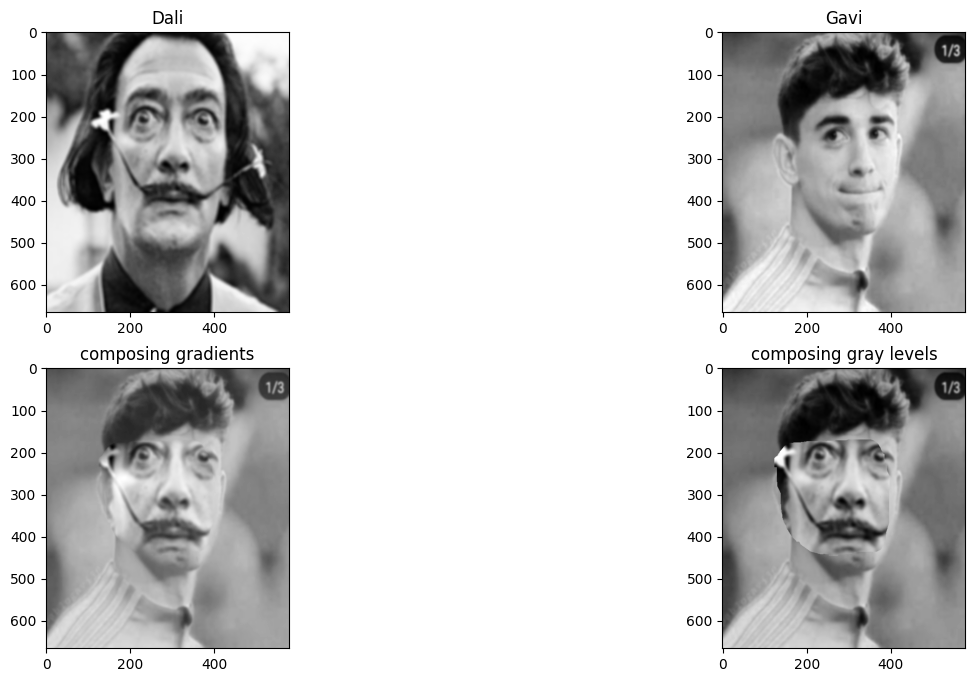

In [369]:
lisa_dali_in_gavi(u21, u11, mask1)